# Figure 1: Association between measusures and identity effects

In [1]:
source('../scripts/load_libraries.R')
source('../scripts/load_constants.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [2]:
source('../scripts/load_data.R')

Rows: 17264341 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): comment_id, user_id, author_id, anonymous, first_view

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1281001 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, score, time_stamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 223737 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, num, time_stamp

ℹ Use `spec()` t

In [3]:
source('../scripts/load_moderator_variables.R')

`summarise()` has grouped output by 'author_id'. You can override using the `.groups` argument.
Joining, by = c("author_id", "ds")
Joining, by = c("author_id", "ds")
Joining, by = c("user_id", "author_id", "ds")


## Reputation

In [4]:
reputation_sum <- df_with_covariates %>%
  mutate(reputation = round(reputation))  %>%
  group_by(identified, reputation) %>%
  summarise(up = sum(up), 
            dn = sum(dn),
            rp = sum(rp),
            cnt = n())

nrow(reputation_sum)
head(reputation_sum)

`summarise()` has grouped output by 'identified'. You can override using the `.groups` argument.


[1] 101

identified,reputation,up,dn,rp,cnt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,-27,0,6,0,13
0,-26,0,0,0,2
0,-24,0,0,0,3
0,-23,0,3,0,21
0,-21,0,0,0,10
0,-20,0,0,0,6


In [5]:
reputation_probs <- reputation_sum %>% 
  ungroup() %>%
  gather(outcome, value, up, dn, rp) %>%
  group_by(identified, outcome) %>%
  ebbr::add_ebb_estimate(value, cnt) %>%
  ungroup() %>%
  mutate(Condition = if_else(identified == 1, 'Identified', 'Anonymous')) %>%
  mutate(outcome = fct_relevel(factor(outcome), c('up', 'dn', 'rp')),
         outcome = fct_recode(factor(outcome), 
                              `Up-vote` = 'up', `Down-vote` = 'dn', `Reply` = 'rp'))

nrow(reputation_probs)
head(reputation_probs)

Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


[1] 303

identified,reputation,cnt,outcome,value,.alpha1,.beta1,.fitted,.raw,.low,.high,Condition
<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-27,13,Up-vote,0,0.6992582,34.19047,0.02004195,0,0.0001313499,0.08485242,Anonymous
0,-26,2,Up-vote,0,0.6992582,23.19047,0.02927024,0,0.0001940498,0.12277835,Anonymous
0,-24,3,Up-vote,0,0.6992582,24.19047,0.02809424,0,0.0001859793,0.11798629,Anonymous
0,-23,21,Up-vote,0,0.6992582,42.19047,0.01630363,0,0.0001063568,0.06928093,Anonymous
0,-21,10,Up-vote,0,0.6992582,31.19047,0.02192738,0,0.0001440434,0.09266070,Anonymous
0,-20,6,Up-vote,0,0.6992582,27.19047,0.02507225,0,0.0001653485,0.10561685,Anonymous


In [6]:
reputation_cnt <- reputation_sum %>%
  group_by(reputation) %>%
  summarise(cnt = sum(cnt))

nrow(reputation_cnt)
head(reputation_cnt)

[1] 51

reputation,cnt
<dbl>,<int>
-27,215
-26,97
-24,48
-23,367
-22,30
-21,176


Joining, by = "reputation"
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


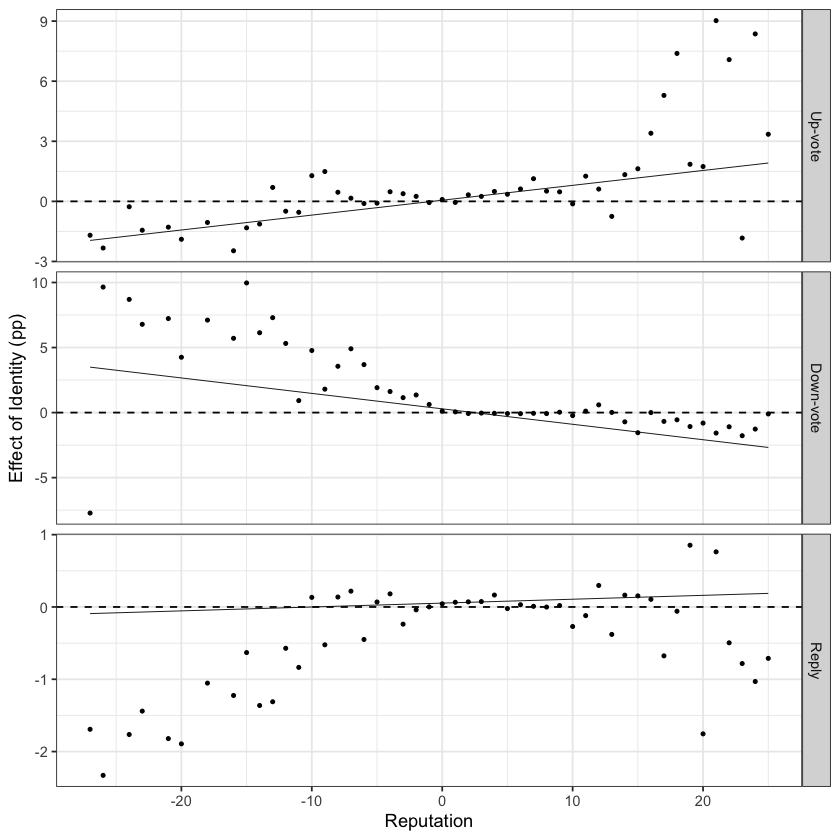

In [7]:
p <- reputation_probs %>%
  select(outcome, Condition, reputation, .fitted) %>%
  spread(Condition, .fitted) %>%
  mutate(pp = 100 * (Identified - Anonymous)) %>%
  inner_join(reputation_cnt) %>%
  ggplot(aes(x = reputation, y = pp)) + 
  geom_point(size = 0.75) +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  facet_grid(outcome ~ ., scales = 'free_y') +
  xlab('Reputation') +
  ylab('Effect of Identity (pp)') +
  geom_smooth(aes(weight = cnt), method = 'lm', se = FALSE, colour = 'black', size = .25) +
  theme_bw()
p

In [8]:
ggsave('../figures/fig-1a.pdf', p, width = 3.5, height = 5)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


## Production

In [9]:
production_sum <- df_with_covariates %>%
  mutate(production = 10 * round(production/10))  %>%
  group_by(identified, production) %>%
  summarise(up = sum(up), 
            dn = sum(dn),
            rp = sum(rp),
            cnt = n())

nrow(production_sum)
head(production_sum)

`summarise()` has grouped output by 'identified'. You can override using the `.groups` argument.


[1] 56

identified,production,up,dn,rp,cnt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,7729,1948,1471,186938
0,10,5465,1190,1075,129928
0,20,3962,939,832,98010
0,30,2238,579,508,56363
0,40,2005,535,441,48807
0,50,1200,296,292,28093


In [10]:
production_probs <- production_sum %>% 
  ungroup() %>%
  gather(outcome, value, up, dn, rp) %>%
  group_by(identified, outcome) %>%
  ebbr::add_ebb_estimate(value, cnt) %>%
  ungroup() %>%
  mutate(Condition = if_else(identified == 1, 'Identified', 'Anonymous')) %>%
  mutate(outcome = fct_relevel(factor(outcome), c('up', 'dn', 'rp')),
         outcome = fct_recode(factor(outcome), 
                              `Up-vote` = 'up', `Down-vote` = 'dn', `Reply` = 'rp'))
nrow(production_probs)
head(production_probs)

[1] 168

identified,production,cnt,outcome,value,.alpha1,.beta1,.fitted,.raw,.low,.high,Condition
<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0,186938,Up-vote,7729,7731.052,179304.72,0.04133462,0.04134526,0.04043713,0.04224139,Anonymous
0,10,129928,Up-vote,5465,5467.052,124558.72,0.04204591,0.04206176,0.04096175,0.04314342,Anonymous
0,20,98010,Up-vote,3962,3964.052,94143.72,0.04040508,0.04042445,0.03918185,0.04164605,Anonymous
0,30,56363,Up-vote,2238,2240.052,54220.72,0.03967448,0.03970690,0.03807995,0.04129990,Anonymous
0,40,48807,Up-vote,2005,2007.052,46897.72,0.04104000,0.04108017,0.03929964,0.04281592,Anonymous
0,50,28093,Up-vote,1200,1202.052,26988.72,0.04263991,0.04271527,0.04031233,0.04502896,Anonymous


In [11]:
production_cnt <- production_sum %>%
  group_by(production) %>%
  summarise(cnt = sum(cnt))

nrow(production_cnt)
head(production_cnt)

[1] 28

production,cnt
<dbl>,<int>
0,3723769
10,2595146
20,1951991
30,1121235
40,980952
50,563363


Joining, by = "production"
`geom_smooth()` using formula 'y ~ x'



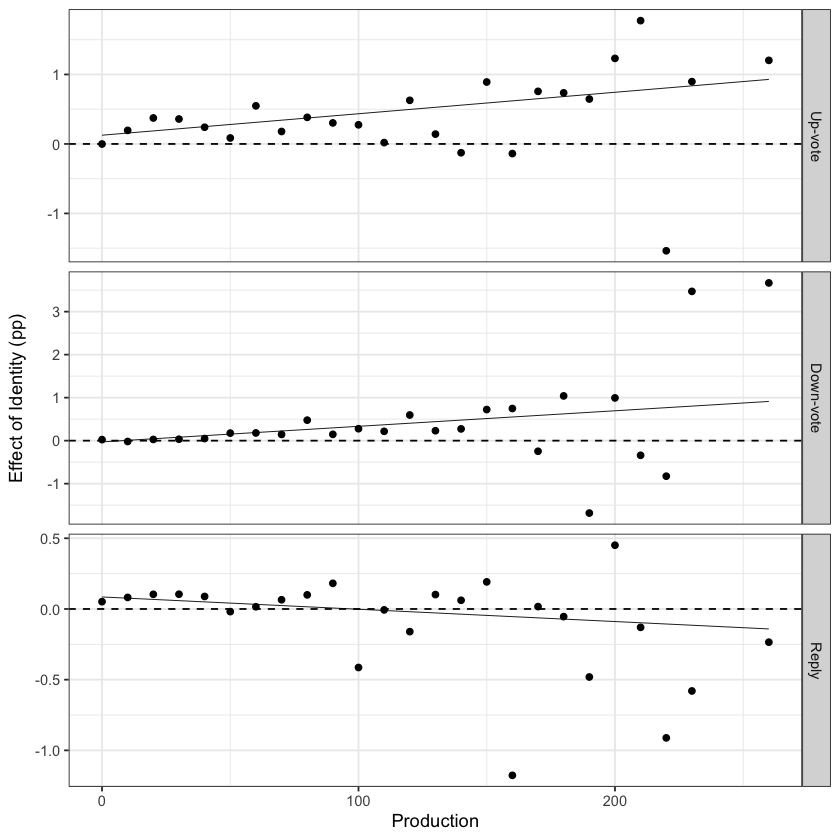

In [12]:
p <- production_probs %>%
  filter(production <= 300) %>%
  select(outcome, Condition, production, .fitted) %>%
  spread(Condition, .fitted) %>%
  mutate(pp = 100*(Identified - Anonymous)) %>%
  inner_join(production_cnt) %>%
  ggplot(aes(x = production, y = pp)) + 
  geom_point() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  facet_grid(outcome ~ ., scales = 'free_y') +
  xlab('Production') +
  ylab('Effect of Identity (pp)') +
  geom_smooth(aes(weight = cnt), method = 'lm', se = FALSE, colour = 'black', size = .25) +
  theme_bw()
p

In [13]:
ggsave('../figures/fig-1b.pdf', p, width = 3.5, height = 5)

`geom_smooth()` using formula 'y ~ x'



## Reciprocity

In [14]:
reciprocity_sum <- df_with_covariates %>%
  filter(!is.na(reciprocity)) %>%
  mutate(reciprocity = round(reciprocity, 1))  %>%
  group_by(identified, reciprocity) %>%
  summarise(up = sum(up), 
            dn = sum(dn),
            rp = sum(rp),
            cnt = n())

nrow(reciprocity_sum)
head(reciprocity_sum)

`summarise()` has grouped output by 'identified'. You can override using the `.groups` argument.


[1] 42

identified,reciprocity,up,dn,rp,cnt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,-1.0,0,0,1,2
0,-0.9,0,0,2,14
0,-0.8,3,5,2,38
0,-0.7,3,3,1,66
0,-0.6,1,7,7,97
0,-0.5,9,10,20,189


In [15]:
reciprocity_probs <- reciprocity_sum %>% 
  ungroup() %>%
  gather(outcome, value, up, dn, rp) %>%
  group_by(identified, outcome) %>%
  ebbr::add_ebb_estimate(value, cnt) %>%
  ungroup() %>%
  mutate(Condition = if_else(identified == 1, 'Identified', 'Anonymous')) %>%
  mutate(outcome = fct_relevel(factor(outcome), c('up', 'dn', 'rp')),
         outcome = fct_recode(factor(outcome), 
                              `Up-vote` = 'up', `Down-vote` = 'dn', `Reply` = 'rp'))

nrow(reciprocity_probs)
head(reciprocity_probs)

[1] 126

identified,reciprocity,cnt,outcome,value,.alpha1,.beta1,.fitted,.raw,.low,.high,Condition
<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-1.0,2,Up-vote,0,0.9310966,15.37011,0.05711826,0.00000000,0.0012154340,0.20623394,Anonymous
0,-0.9,14,Up-vote,0,0.9310966,27.37011,0.03289954,0.00000000,0.0006820674,0.12153668,Anonymous
0,-0.8,38,Up-vote,3,3.9310966,48.37011,0.07516263,0.07894737,0.0209558156,0.15966739,Anonymous
0,-0.7,66,Up-vote,3,3.9310966,76.37011,0.04895439,0.04545455,0.0134660669,0.10536137,Anonymous
0,-0.6,97,Up-vote,1,1.9310966,109.37011,0.01735019,0.01030928,0.0020112089,0.04842398,Anonymous
0,-0.5,189,Up-vote,9,9.9310966,193.37011,0.04884918,0.04761905,0.0237175119,0.08233587,Anonymous


In [16]:
reciprocity_cnt <- reciprocity_sum %>%
  group_by(reciprocity) %>%
  summarise(cnt = sum(cnt))

nrow(reciprocity_cnt)
head(reciprocity_cnt)

[1] 21

reciprocity,cnt
<dbl>,<int>
-1.0,141
-0.9,233
-0.8,735
-0.7,1319
-0.6,1725
-0.5,3766


Joining, by = "reciprocity"
`geom_smooth()` using formula 'y ~ x'



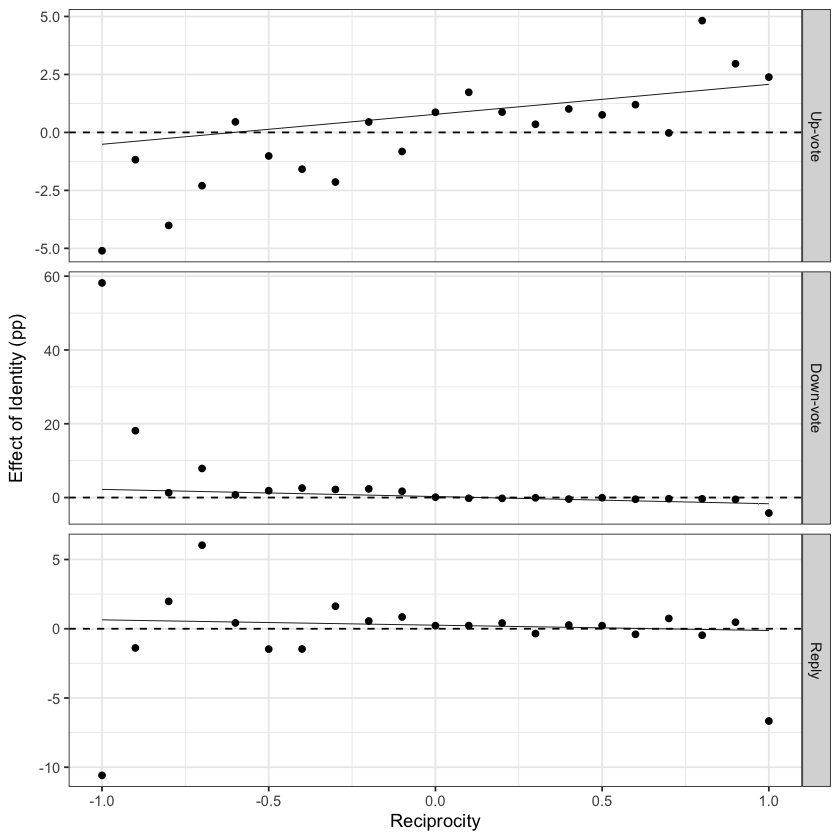

In [17]:
p <- reciprocity_probs %>%
  select(outcome, Condition, reciprocity, .fitted) %>%
  spread(Condition, .fitted) %>%
  mutate(pp = 100 * (Identified - Anonymous)) %>%
  inner_join(reciprocity_cnt) %>%
  ggplot(aes(x = reciprocity, y = pp)) + 
  geom_point() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  facet_grid(outcome ~ ., scales = 'free_y') +
  xlab('Reciprocity') +
  ylab('Effect of Identity (pp)') +
  geom_smooth(aes(weight = cnt), method = 'lm', se = FALSE, colour = 'black', size = .25) +
  theme_bw()
p

In [18]:
ggsave('../figures/fig-1c.pdf', p, width = 3.5, height = 5)

`geom_smooth()` using formula 'y ~ x'

